## Definitions

In [23]:
! pip install statsmodels
! pip install pytest
! pip install numpy nibabel nilearn neuroimagingtools

In [30]:
import scipy.io as sio
import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
import pandas as pd
import surfAnalysisPy as surf
import SUITPy as suit
import nibabel as nb
import nitools as nt
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from pathlib import Path
import seaborn as sns
import PcmPy as pcm
import Functional_Fusion.atlas_map as am
import glob
import matplotlib.patches as patches

# SET PATHS:
# baseDir = '/Volumes/Diedrichsen_data$/data/Chord_exp/EFC_patternfMRI'
baseDir = '/Users/alighavampour/Desktop/Projects/EFC_patternfMRI/data/efcp_fMRI'
# baseDir = '/Users/ali/Desktop/Projects/EFC_patternfMRI/data/fMRI'
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'


## TIME SERIES

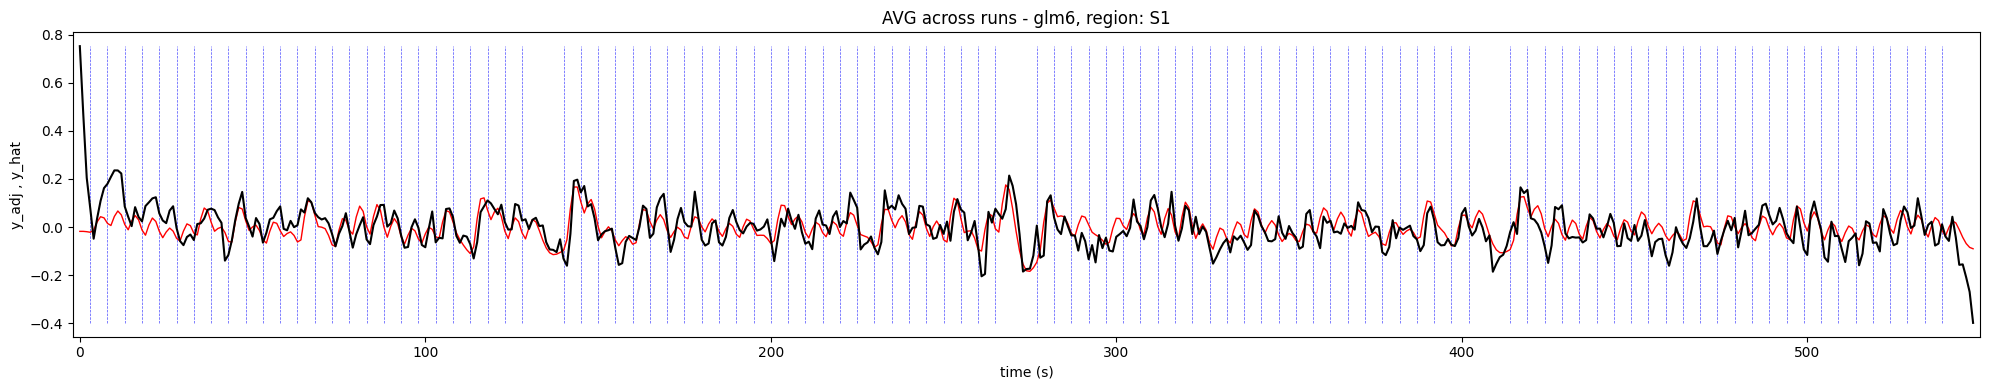

In [345]:
sn = 101
glm = 6
ses = 2
region = 1

# for cutting time series:
pre_idx = 6
post_idx = 16
TR = 1

roi_names = ['', 'S1', 'M1', 'PMd', 'PMv', 'SMA', 'V1', 'SPLa', 'SPLp']

D = pd.read_table(os.path.join(baseDir, behavDir, f's{sn}', f'ses-{ses:02d}', f'efc4_{sn}.dat'))
T = sio.loadmat(os.path.join(baseDir, regDir, f's{sn}', f'ses-{ses:02d}', f'time_series_glm{glm}.mat'), simplify_cells=True)
SPM = sio.loadmat(os.path.join(baseDir, f'glm{glm}', f's{sn}', f'ses-{ses:02d}', 'SPM_v7.mat'), simplify_cells=True)
SPM = SPM['SPM']

X = SPM['xX']['X']
y_pred = np.sum(X[0:549, :], axis=1) - np.mean(np.sum(X[0:549, :], axis=1))
y_adj = T['y_adj']
y_hat = T['y_hat']
y_run_avg = np.zeros(549)
y_hat_avg = np.zeros(549)
y_pred = np.sum(SPM['xX']['X'][:549, :], axis=1) - np.mean(np.sum(SPM['xX']['X'][:549, :], axis=1))
y_pred = y_pred * 50
for run in range(0, 8):
    row = SPM['Sess'][run]['row']-1
    t = np.arange(0, len(row), 1)
    ons = D[D['BN']==run+1]['startTimeReal']/1000

    fig, ax = plt.subplots(1, 1, figsize=(20, 4))
    ax.vlines(ons, ymin=min(y_adj[row, region]), ymax=max(y_adj[row, region]), colors='b', lw=0.5, alpha=0.7, linestyles='--')
    # plt.plot(t, y_pred, color='r', ls='--', lw=0.7, alpha=0.6)
    plt.plot(t, y_hat[row, region], color='r', lw=1.5)
    plt.plot(t, y_adj[row, region], color='k', lw=1)
    plt.xlabel('time (s)')
    plt.ylabel('y adj')
    plt.xlim((t[0]-2, t[-1]+2))
    plt.title(f'run {run+1} - glm{glm}, region: {roi_names[region]}')
    plt.tight_layout()
    plt.savefig(f'./figures/efcp_Yadj_Yhat_glm{glm}_ses{ses}_run{run+1:02d}_{roi_names[region]}.pdf', bbox_inches="tight")
    # plt.show()
    plt.close()
    y_run_avg += y_adj[row, region]/8
    y_hat_avg += y_hat[row, region]/8

fig, ax = plt.subplots(1, 1, figsize=(20, 4))
ax.vlines(ons, ymin=min(y_run_avg), ymax=max(y_run_avg), colors='b', lw=0.5, alpha=0.7, linestyles='--')
# plt.plot(t, y_pred, color='r', ls='--', lw=0.7, alpha=0.6)
plt.plot(t, y_hat_avg, color='r', lw=1)
plt.plot(t, y_run_avg, color='k', lw=1.5)
plt.xlabel('time (s)')
plt.ylabel('y_adj , y_hat')
plt.xlim((t[0]-2, t[-1]+2))
plt.title(f'AVG across runs - glm{glm}, region: {roi_names[region]}')
plt.tight_layout()
plt.savefig(f'./figures/efcp_Yadj_Yhat_glm{glm}_ses{ses}_avg_{roi_names[region]}.pdf', bbox_inches="tight")
plt.show()

'''
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
TIME LOCKING AND AVERAGING THE TIME SERIES 
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
'''
def extract_snippets(y, pre, post, onsets):
    snippets_y = []

    for onset in onsets:
        start_idx = onset - pre
        end_idx = onset + post

        snippet_y = np.full(pre + post + 1, np.nan)
        
        valid_start = int(max(0, start_idx))
        valid_end = int(min(len(y), end_idx + 1))
        
        insert_start = int(valid_start - start_idx)
        insert_end = int(insert_start + (valid_end - valid_start))

        snippet_y[insert_start:insert_end] = y[valid_start:valid_end]
        
        snippets_y.append(snippet_y)
            
    return np.array(snippets_y)

# load the events:
events = pd.read_table(os.path.join(baseDir, behavDir, f's{sn}', f'ses-{ses:02d}', f'glm{glm}_events.tsv'))

# find the onsets of the events:
# T = events.copy()
# T['y_adj'] = np.nan
# T['y_hat'] = np.nan
T = pd.DataFrame()

blocks = np.unique(events['BN'])
for r in range(np.shape(y_adj)[1]):
    for i, BN in enumerate(blocks):
        tmp = pd.DataFrame()
        y_adj_reg = y_adj[SPM['Sess'][i]['row']-1, r]
        y_hat_reg = y_hat[SPM['Sess'][i]['row']-1, r]
        onsets = events[events['BN']==BN]['Onset']
        y_adj_cut = extract_snippets(y_adj_reg, pre_idx, post_idx, onsets)
        y_hat_cut = extract_snippets(y_hat_reg, pre_idx, post_idx, onsets)

        tmp = pd.concat([tmp, events[events['BN']==BN]], axis=1).reset_index(drop=True)
        tmp['region'] = r

        col_names = [f"y_adj{i}" for i in range(y_adj_cut.shape[1])]
        df_y_adj = pd.DataFrame(y_adj_cut, columns=col_names)
        tmp = pd.concat([tmp, df_y_adj], axis=1).reset_index(drop=True)

        col_names = [f"y_hat{i}" for i in range(y_hat_cut.shape[1])]
        df_y_hat = pd.DataFrame(y_hat_cut, columns=col_names)
        tmp = pd.concat([tmp, df_y_hat], axis=1).reset_index(drop=True)
        
        T = pd.concat([T, tmp], axis=0).reset_index(drop=True)

T.to_csv(os.path.join(baseDir, regDir, f's{sn}', f'ses-{ses:02d}', f'time_series_cut_glm{glm}.csv'), index=False)


## TIME SERIES CUT

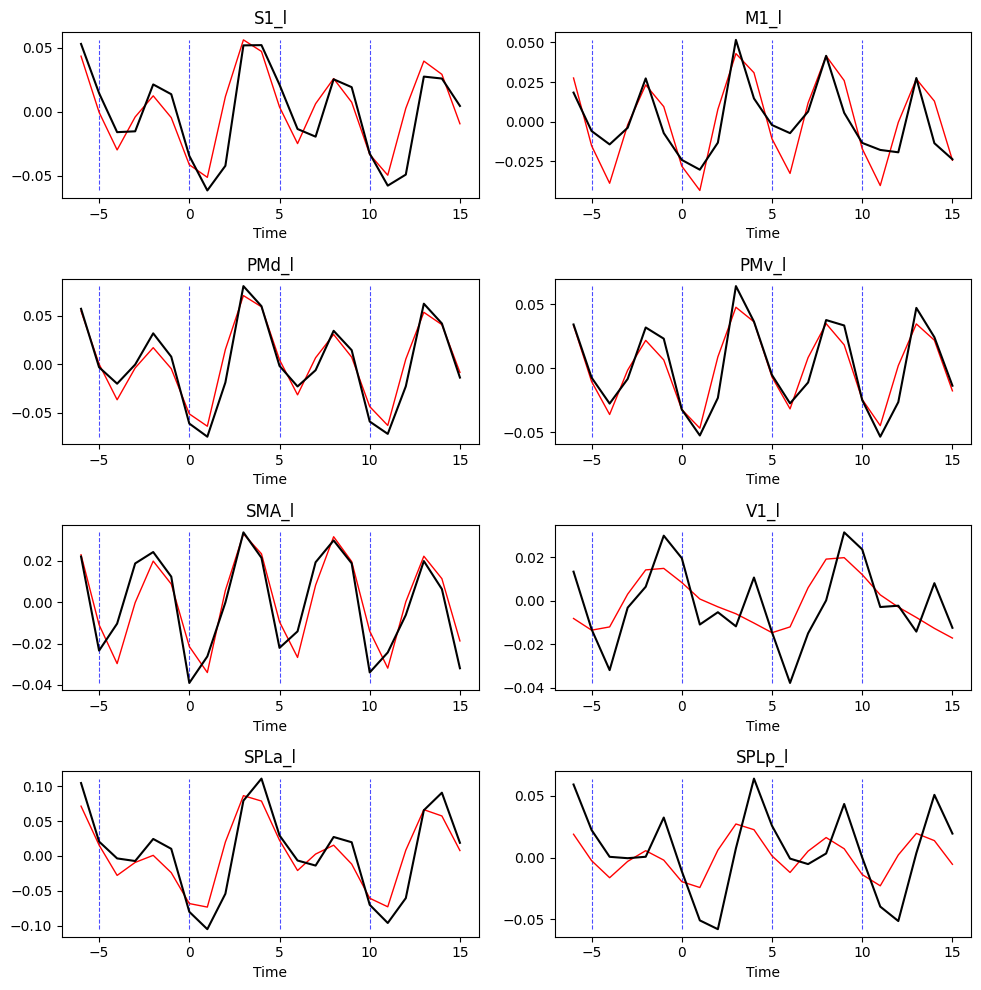

In [355]:
sn = 101
glm = 6
ses = 2

T = pd.read_csv(os.path.join(baseDir, regDir, f's{sn}', f'ses-{ses:02d}', f'time_series_cut_glm{glm}.csv'))
T = T[T['repetition']==1]
t = np.arange(-6, 16, 1)
roi_names = ['_l', 'S1_l', 'M1_l', 'PMd_l', 'PMv_l', 'SMA_l', 'V1_l', 'SPLa_l', 'SPLp_l', '_r', 'S1_r', 'M1_r', 'PMd_r', 'PMv_r', 'SMA_r', 'V1_r', 'SPLa_r', 'SPLp_r']

n_row = 4
n_col = 2
fig, axes = plt.subplots(n_row, n_col, figsize=(10, 10))
for j, r in enumerate(range(1,9)):
    y_adj = T.loc[T['region']==r, [f'y_adj{i}' for i in range(len(t))]].mean().to_list()
    y_hat = T.loc[T['region']==r, [f'y_hat{i}' for i in range(len(t))]].mean().to_list()

    ax = axes[j//n_col, j%n_col]
    ax.vlines([-5,0,5,10], ymin=min(min(y_adj),min(y_hat)), ymax=max(max(y_adj),max(y_hat)), color='b', ls='--', lw=0.8, alpha=0.7)
    ax.plot(t, y_hat, color='r', lw=1)
    ax.plot(t, y_adj, color='k', lw=1.5)
    ax.set_title(f'{roi_names[r]}')
    ax.set_xlabel('Time')

plt.tight_layout()
plt.savefig(f'./figures/efcp_Yhat_Yadj_my_glm{glm}_ses{ses}.pdf', bbox_inches="tight")
plt.show()

## Projection of t-values on surface

In [402]:
sn = 101
glm = 6
ses = 2

spmTs = list(Path(os.path.join(baseDir, f'glm{glm}', f's{sn}', f'ses-{ses:02d}')).glob("spmT_*.nii"))
# spmTs = [spmTs[5]]

# 2. Define the relevant gifti files for both left and right hemisphere:
surf_white = [] # White -gray matter surface 
surf_pial = []  # Pial surface 
surf_sulc = []  # Sulcal depth 
hemN = ['L','R']
for h,hem in enumerate(hemN):
    surf_white.append(os.path.join(baseDir,surfacewbDir, f's{sn}', f's{sn}.{hem}.white.32k.surf.gii'))
    surf_pial.append(os.path.join(baseDir,surfacewbDir, f's{sn}', f's{sn}.{hem}.pial.32k.surf.gii'))
    surf_sulc.append(os.path.join(baseDir,surfacewbDir, f's{sn}', f's{sn}.{hem}.sulc.32k.shape.gii'))

# Map a Nifti to the surface of left hemisphere 
DL = surf.map.vol_to_surf(spmTs,surf_pial[0], surf_white[0], excludeThres=0.9)
# Map a Nifti to the surface of right hemisphere 
DR = surf.map.vol_to_surf(spmTs,surf_pial[1],surf_white[1],  excludeThres=0.9)

D = {'L':DL, 'R':DR}

/var/folders/5y/1pn48fgn7yb77gc17h_5jms80000gp/T/ipykernel_82166/3670302172.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


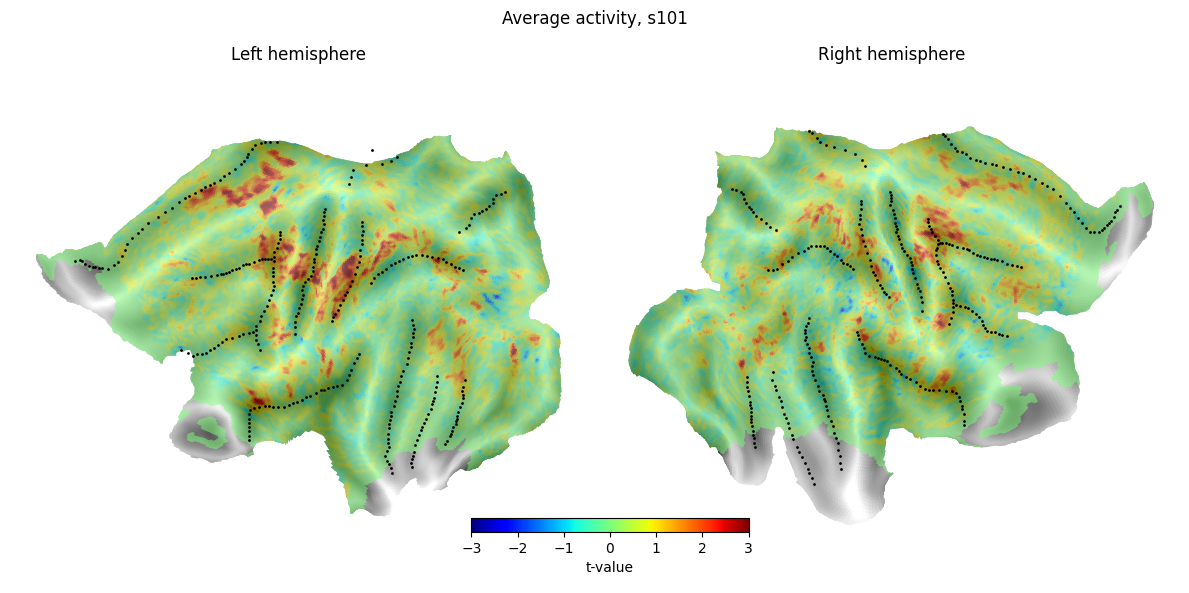

In [403]:
Hem = ['L', 'R']
region_names = ['?', 'S1', 'M1', 'PMd', 'PMv', 'SMA', 'V1', 'SPLa', '?']
Hem = ['L', 'R']
borders = {'L': './surfAnalysisPy/standard_mesh/fs_L/fs_LR.32k.L.border',
           'R': './surfAnalysisPy/standard_mesh/fs_R/fs_LR.32k.R.border'}

vmin, vmax = -3, 3
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for ax, H in zip(axs, Hem):
    plt.sca(ax)
    surf.plot.plotmap(D[H].mean(axis=1), f'fs32k_{H}',
                        underlay=None,
                        borders=borders[H],
                        cscale=[vmin, vmax],
                        cmap='jet',
                        underscale=[-1.5, 1],
                        alpha=.5,
                        new_figure=False,
                        colorbar=False,
                        # frame=[xlim[0], xlim[1], ylim[0], ylim[1]]
                        )
# make colorbar
norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = ScalarMappable(norm=norm, cmap='jet')
cbar = fig.colorbar(sm, ax=[axs[0], axs[1]], orientation='horizontal', fraction=0.03)
cbar.set_label('t-value')

axs[0].set_title('Left hemisphere')
axs[1].set_title('Right hemisphere')
fig.suptitle(f'Average activity, s{sn}')
fig.tight_layout()
plt.savefig(f'./figures/efcp_spmT2surf_glm{glm}_ses{ses}.pdf', bbox_inches="tight")


## MAKE GLM DATAFRAME

In [8]:
sn = 101
glm = 4
region_labels = [1, 2, 3, 4, 5, 6, 7, 8]
region_names = ['S1', 'M1', 'PMd', 'PMv', 'SMA', 'V1', 'SPLa', 'SPLp']

for ses in [1,2]:
    #  Define atlas map
    white = os.path.join(baseDir, surfacewbDir, f's{sn}', f's{sn}.L.white.32k.surf.gii') # Individual white surface
    pial = os.path.join(baseDir, surfacewbDir, f's{sn}', f's{sn}.L.pial.32k.surf.gii') # Invividual pial surface
    mask = os.path.join(baseDir, f'glm{glm}', f's{sn}', f'ses-{ses:02d}', 'mask.nii') # Mask in functional space for that subject

    # File names for data extraction
    nii_names = sorted(glob.glob(os.path.join(baseDir, f'glm{glm}', f's{sn}', f'ses-{ses:02d}', "beta_*.nii")))
    nii_names = nii_names[0:416] # remove the run constant regressors
    resMS_name = [os.path.join(baseDir, f'glm{glm}', f's{sn}', f'ses-{ses:02d}', 'ResMS.nii')]
    spmT_names = glob.glob(os.path.join(baseDir, f'glm{glm}', f's{sn}', f'ses-{ses:02d}', "spmT*.nii"))

    beta = []
    resMS = []
    beta_white = []
    spmT = []
    for i, r in enumerate(region_labels):
        print(f'Extracting region {region_names[i]} ({r})')
        atlas,_ = am.get_atlas('fs32k')
        atlas_left = atlas.get_hemisphere(0)
        subatlas = atlas_left.get_subatlas_image(os.path.join(atlasDir,'ROI.32k.L.label.gii'), value=r)
        amap = am.AtlasMapSurf(subatlas.vertex[0],white,pial,mask) # Atlas map
        # Compute the voxels in native space
        amap.build()

        # save the ROI mask in native space for checking purposes
        amap.save_as_image(os.path.join(baseDir, regDir, f's{sn}', f'ses-{ses:02d}', f'amap_ROI_glm{glm}_{region_names[i]}.nii'))
        
        # This extract all the relevant voxels in native space (use for RSA)
        beta.append(amap.extract_data_native(nii_names))
        resMS.append(amap.extract_data_native(resMS_name))
        beta_white.append(beta[i]/np.sqrt(resMS[i]))
        spmT.append(amap.extract_data_native(spmT_names))

    regressor_info = pd.read_table(os.path.join(baseDir, f'glm{glm}', f's{sn}', f'ses-{ses:02d}', 'reginfo.tsv'))


    # -Turn the extracted data into a flat df:
    # ---------------------------------------------------------------------------------------------------
    # make the df columns:
    cols = ['sn', 'glm', 'ses', 'run', 'region_label', 'region_name', 'ResMS']
    runs = regressor_info['run'].values
    regressors = regressor_info['name'].values
    conds = [s.split(":")[1].split(",")[0] + "_rep" + s.split(":")[2] for s in regressors[:52]]
    cols.extend(conds)

    # Convert key DataFrame columns to NumPy arrays for faster access
    regressor_runs = regressor_info['run'].to_numpy()
    regressor_indices = {run: np.where(regressor_runs == run)[0] for run in np.unique(regressor_runs)}

    # Preallocate list for bulk DataFrame creation
    data_list = []
    # Iterate over regions
    for i, r in enumerate(region_labels):
        b_map = beta[i]  # numRegressors x P matrix
        resMS_map = resMS[i].flatten().astype(float)  # (P, ) array

        for run in runs:
            idx = regressor_indices[run]  # Retrieve indices for the run
            b_run = b_map[idx, :]  # numCondition x P matrix of beta values

            # Vectorized storage of multiple rows at once
            run_data = np.column_stack([
                np.full(len(resMS_map), int(sn), dtype=int),
                np.full(len(resMS_map), int(glm), dtype=int),
                np.full(len(resMS_map), int(ses), dtype=int),
                np.full(len(resMS_map), int(run), dtype=int),
                np.full(len(resMS_map), int(r), dtype=int),
                np.full(len(resMS_map), str(region_names[i]), dtype=object),
                resMS_map.astype(float)
            ])

            # Convert to dictionary and append
            for p, row in enumerate(run_data):
                row_dict = dict(zip(cols[:7], row))  # First 7 columns (fixed values)
                row_dict.update(dict(zip(conds, b_run[:, p])))  # Assign beta values
                data_list.append(row_dict)

    # Convert accumulated data into DataFrame at once
    glm_df = pd.DataFrame(data_list)
    glm_df.to_csv(os.path.join(baseDir, f'glm{glm}', f's{sn}', f'ses-{ses:02d}', f's{sn}_glm{glm}.csv'), index=False)


Extracting region S1 (1)
Extracting region M1 (2)
Extracting region PMd (3)
Extracting region PMv (4)
Extracting region SMA (5)
Extracting region V1 (6)
Extracting region SPLa (7)
Extracting region SPLp (8)
Extracting region S1 (1)
Extracting region M1 (2)
Extracting region PMd (3)
Extracting region PMv (4)
Extracting region SMA (5)
Extracting region V1 (6)
Extracting region SPLa (7)
Extracting region SPLp (8)


In [5]:
sn = 101
glm = 4

pd.read_csv(os.path.join(baseDir, f'glm{glm}', f's{sn}', f's{sn}_glm{glm}.csv'))

,sn,glm,ses,run,region_label,region_name,ResMS,91119_rep1,91119_rep2,91129_rep1,...,99219_rep1,99219_rep2,99229_rep1,99229_rep2,99299_rep1,99299_rep2,99919_rep1,99919_rep2,99929_rep1,99929_rep2
0,101,4,1,1,1,S1,56.030602,85.051224,50.119484,-377.818329,...,201.674850,308.709259,57.599815,53.566174,135.116486,80.969673,-353.027130,-91.870644,152.672821,-110.121269
1,101,4,1,1,1,S1,50.013495,256.893768,113.645935,50.281750,...,199.715393,89.387527,-240.369827,68.295731,-218.302582,-202.544952,-89.333534,-216.905304,-192.821243,-426.608521
2,101,4,1,1,1,S1,67.282639,549.293457,-107.896210,-125.180313,...,277.692017,185.975632,520.607666,603.220703,286.146301,236.001801,-253.108856,36.055500,127.965599,519.287231
3,101,4,1,1,1,S1,54.012322,76.195641,37.984833,130.791885,...,-139.402756,92.419212,114.662895,-136.355576,-117.351044,-70.299240,-303.545959,-135.079437,-284.981689,-212.974716
4,101,4,1,1,1,S1,74.018346,541.657227,-172.495499,-124.384605,...,-382.171783,-307.055481,459.304077,532.033386,-68.967567,-31.780090,-60.667309,-353.872681,-56.002373,-36.916042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5989147,101,4,2,8,8,SPLp,149.789852,-323.571808,436.515167,904.773499,...,273.366455,587.635254,262.778503,18.659986,92.730843,77.650337,-386.651978,-600.572876,-56.086369,-31.235228
5989148,101,4,2,8,8,SPLp,215.714095,59.921318,-201.887665,-274.281067,...,214.426727,737.152893,87.897934,444.838531,-286.419373,431.388824,327.145203,-232.957275,41.922577,394.145508
5989149,101,4,2,8,8,SPLp,194.222063,-675.958313,-93.279114,-763.683105,...,-16.366884,-960.747925,-212.688217,-276.483948,-195.496902,-540.035583,420.011963,-79.954102,-244.480270,-321.577423
5989150,101,4,2,8,8,SPLp,333.558699,-132.397079,569.662781,530.438721,...,862.758606,-804.954590,1165.145020,-25.255323,-426.528320,-871.774597,-441.173431,-923.050537,385.059326,373.793457


## MVPA

In [3]:
sn = 101
glm = 4
ses = 2
region_labels = [1, 2, 3, 4, 5, 6, 7, 8]
region_names = ['S1', 'M1', 'PMd', 'PMv', 'SMA', 'V1', 'SPLa', 'SPLp']

#  Define atlas map
white = os.path.join(baseDir, surfacewbDir, f's{sn}', f's{sn}.L.white.32k.surf.gii') # Individual white surface
pial = os.path.join(baseDir, surfacewbDir, f's{sn}', f's{sn}.L.pial.32k.surf.gii') # Invividual pial surface
mask = os.path.join(baseDir, f'glm{glm}', f's{sn}', f'ses-{ses:02d}', 'mask.nii') # Mask in functional space for that subject

# File names for data extraction
nii_names = sorted(glob.glob(os.path.join(baseDir, f'glm{glm}', f's{sn}', f'ses-{ses:02d}', "beta_*.nii")))
nii_names = nii_names[0:416] # remove the run constant regressors
resMS_name = [os.path.join(baseDir, f'glm{glm}', f's{sn}', f'ses-{ses:02d}', 'ResMS.nii')]
spmT_names = glob.glob(os.path.join(baseDir, f'glm{glm}', f's{sn}', f'ses-{ses:02d}', "spmT*.nii"))

beta = []
resMS = []
beta_white = []
spmT = []
for i, r in enumerate(region_labels):
    print(f'Extracting region {region_names[i]} ({r})')
    atlas,_ = am.get_atlas('fs32k')
    atlas_left = atlas.get_hemisphere(0)
    subatlas = atlas_left.get_subatlas_image(os.path.join(atlasDir,'ROI.32k.L.label.gii'), value=r)
    amap = am.AtlasMapSurf(subatlas.vertex[0],white,pial,mask) # Atlas map
    # Compute the voxels in native space
    amap.build()

    # save the ROI mask in native space for checking purposes
    amap.save_as_image(os.path.join(baseDir, regDir, f's{sn}', f'ses-{ses:02d}', f'amap_ROI_glm{glm}_{region_names[i]}.nii'))
    
    # This extract all the relevant voxels in native space (use for RSA)
    beta.append(amap.extract_data_native(nii_names))
    resMS.append(amap.extract_data_native(resMS_name))
    beta_white.append(beta[i]/np.sqrt(resMS[i]))
    spmT.append(amap.extract_data_native(spmT_names))

regressor_info = pd.read_table(os.path.join(baseDir, f'glm{glm}', f's{sn}', f'ses-{ses:02d}', 'reginfo.tsv'))


Extracting region S1 (1)
Extracting region M1 (2)
Extracting region PMd (3)
Extracting region PMv (4)
Extracting region SMA (5)
Extracting region V1 (6)
Extracting region SPLa (7)
Extracting region SPLp (8)


### Average T-values

/var/folders/5y/1pn48fgn7yb77gc17h_5jms80000gp/T/ipykernel_82166/1385256167.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=x_reg, y=spmT_avg.flatten(), ax=ax, inner='quart', linewidth=1, fill=0, palette=["000000"], gap=0.5)
/var/folders/5y/1pn48fgn7yb77gc17h_5jms80000gp/T/ipykernel_82166/1385256167.py:12: UserWarning: 
The palette list has fewer values (1) than needed (8) and will cycle, which may produce an uninterpretable plot.
  sns.violinplot(x=x_reg, y=spmT_avg.flatten(), ax=ax, inner='quart', linewidth=1, fill=0, palette=["000000"], gap=0.5)


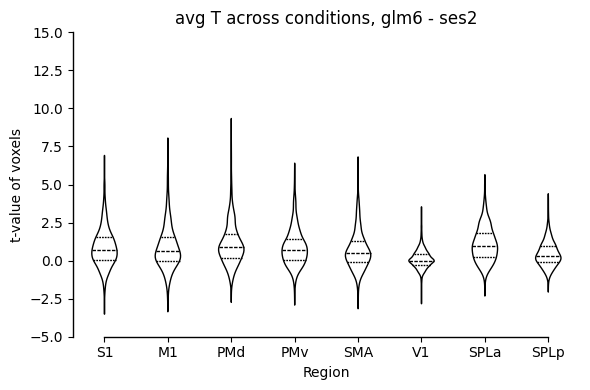

In [378]:
spmT_avg = np.array([])
x_reg = np.array([], dtype=int)
for i, r in enumerate(region_labels):
    t_map = np.mean(spmT[i], axis=0) # avg of t-values across calculated contrasts
    spmT_avg = np.concatenate((spmT_avg, t_map))
    
    # x axis for plotting:
    x_reg = np.concatenate((x_reg, np.full(len(t_map), r, dtype=int)))

# T avg plot:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.violinplot(x=x_reg, y=spmT_avg.flatten(), ax=ax, inner='quart', linewidth=1, fill=0, palette=["000000"], gap=0.5)

ax.set_xticks(np.arange(0,8))
ax.set_xticklabels(region_names)
plt.xlabel('Region')
plt.ylabel('t-value of voxels')
plt.title(f'avg T across conditions, glm{glm} - ses{ses}')
ax.set_ylim(-5, 15)

# Make it pretty:
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)

ax.spines["left"].set_bounds(ax.get_ylim()[0], ax.get_ylim()[-1])
ax.spines["bottom"].set_bounds(ax.get_xticks()[0], ax.get_xticks()[-1])

plt.savefig(os.path.join('./figures',f'efcp_avgT_region_s{sn}_glm{glm}_ses{ses}.pdf'), format='pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()


### Within Subj Reliability

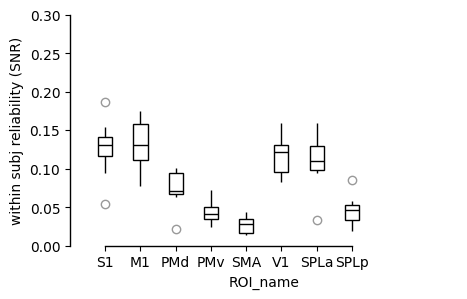

M1+S1 SNR: mean = 12.86349175860616


In [ ]:
import Functional_Fusion.dataset as ds

snr_dict = {
    'ROI': [],
    'ROI_name': [],
    'SNR': []
}

part_vec = regressor_info['run'].values.flatten()
conds = regressor_info['name'].values.flatten()
conds_shortened = [s.split(":")[1].split(",")[0] + "_r" + s.split(":")[2] for s in conds]
conds_chords_only = [s.split(":")[1].split(",")[0] for s in conds]
conds = np.array(conds_chords_only)
# conds = np.array(conds_shortened)

for i, r in enumerate(region_labels):
    X = beta_white[i]   # region data: N by P matrix
    # remove nan columns:
    X = X[:, ~np.isnan(X).all(axis=0)]
    
    snr = ds.reliability_within_subj(X, part_vec, regressor_info['name'].values.flatten(),
                                            voxel_wise=False,
                                            subtract_mean=True)
    
    # Make a n_partition X n_cond X n_voxels matrix:
    # Determine unique conditions and number of partitions
    # N = X.shape[0]
    # P = X.shape[1]
    # unique_conds = np.unique(conds)
    # n_cond = len(unique_conds)
    # n_partition = N // n_cond  # Assumes conditions are evenly distributed across partitions

    # # Create Y by grouping rows based on condition labels
    # Y = np.zeros((n_partition, n_cond, P))  # Initialize output
    # for j, cond in enumerate(unique_conds):  # Loop over conditions
    #     Y[:, j, :] = X[conds == cond]  # Select rows where condition matches

    # snr = ds.decompose_pattern_into_group_indiv_noise([Y], criterion='condition_wise') # DOES NOT WORK WITH ONE SUBEJCT
    
    # Append to data list
    for s in snr:
        snr_dict['ROI'].append(r)
        snr_dict['ROI_name'].append(region_names[i])
        snr_dict['SNR'].append(s)

# Convert to DataFrame
snr_df = pd.DataFrame(snr_dict)

# Define custom properties for the box plot
boxprops = dict(edgecolor='#000000', linewidth=1)
whiskerprops = dict(color='#000000', linewidth=1)
capprops = dict(visible=False)  # Remove the caps
medianprops = dict(color='#000000', linewidth=1)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
sns.boxplot(data=snr_df, x='ROI_name', y='SNR', dodge=True, width=0.4, color='#ffffff', ax=ax,
            boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, medianprops=medianprops)

ax.set_xlim([-1, 10])
ax.set_ylim([0, 0.3])
ax.set_ylabel('within subj reliability (SNR)')

# Make it pretty:
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)

ax.spines["left"].set_bounds(ax.get_ylim()[0], ax.get_ylim()[-1])
ax.spines["bottom"].set_bounds(ax.get_xticks()[0], ax.get_xticks()[-1])

plt.savefig(os.path.join('figures',f'efcp_snr_s{sn}_glm{glm}_ses{ses}.pdf'), format='pdf', bbox_inches='tight')

plt.show()

# print M1 and S1 SNR:
avg_snr = np.mean(snr_df[snr_df['ROI'].isin([1,2])]['SNR'].values)
print(f'M1+S1 SNR: mean = {avg_snr.mean()*100}')

### PCM G AND DISTANCE MATRICES

In [19]:
conds = regressor_info['name'].values.flatten()
conds_shortened = [s.split(":")[1].split(",")[0] + "_r" + s.split(":")[2] for s in conds]
conds_chords_only = [s.split(":")[1].split(",")[0] for s in conds]

conds = np.array(conds_chords_only)
# conds = np.array(conds_shortened)

# Estimate and plot the second moment matrices
n_cond = len(np.unique(conds))
G_hat = np.zeros((len(region_labels), n_cond, n_cond))
D = np.zeros((len(region_labels), n_cond, n_cond))
for i, r in enumerate(region_labels):
    Y = beta_white[i]

    # remove nan voxels:
    cols_with_nan = np.isnan(Y).any(axis=0)  # Boolean array, True where columns have NaN
    # Get columns without NaN values
    cols_without_nan = ~cols_with_nan  # Invert the boolean mask
    # Create new array with only the non-NaN columns
    Y = Y[:, cols_without_nan]

    partition_vec = regressor_info['run'].values.flatten()
    cond_vec = conds.flatten()
    
    G_hat[i,:,:],_ = pcm.est_G_crossval(Y,
                                        cond_vec,
                                        partition_vec,
                                        X=pcm.matrix.indicator(partition_vec))
    D[i,:,:] = pcm.G_to_dist(G_hat[i,:,:])
    
    neg_count_region = np.sum(D[i,:,:] < 0)
    total_region = D[i].size
    neg_percentage_region = (neg_count_region / total_region) * 100
    print(f"{region_names[i]} negative distances = ({neg_percentage_region:.2f}%)")

S1 negative distances = (13.91%)
M1 negative distances = (10.95%)
PMd negative distances = (33.14%)
PMv negative distances = (40.53%)
SMA negative distances = (47.04%)
V1 negative distances = (5.03%)
SPLa negative distances = (28.11%)
SPLp negative distances = (39.35%)


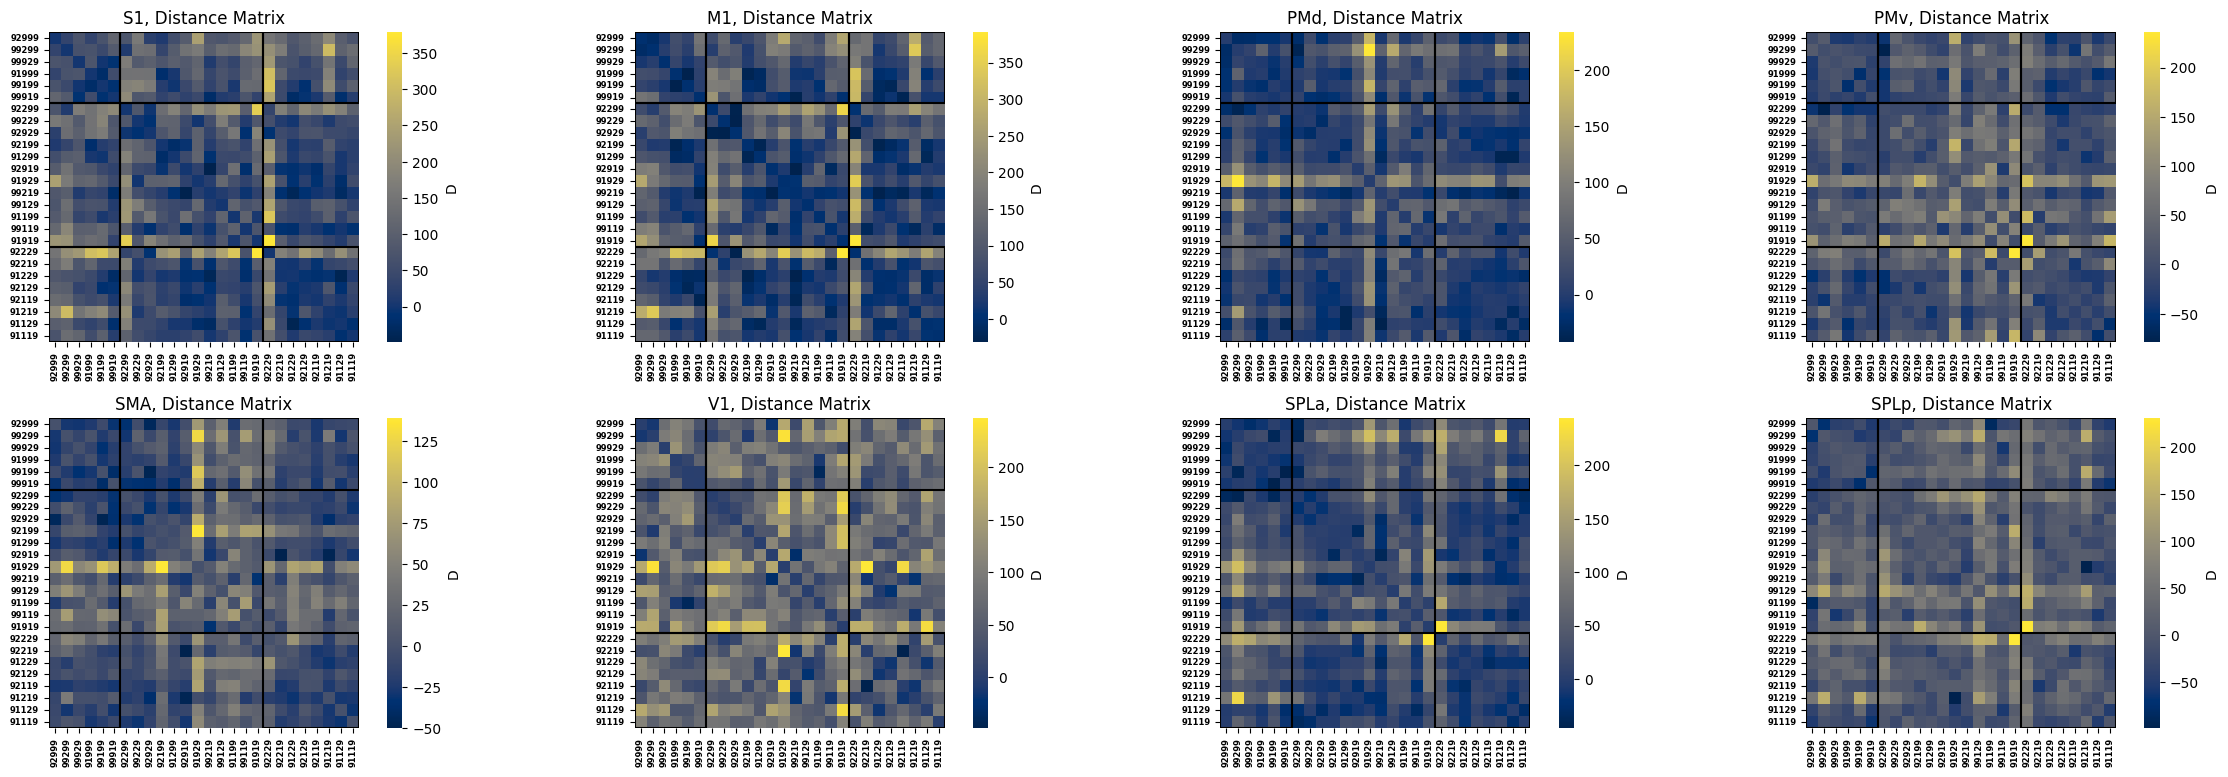

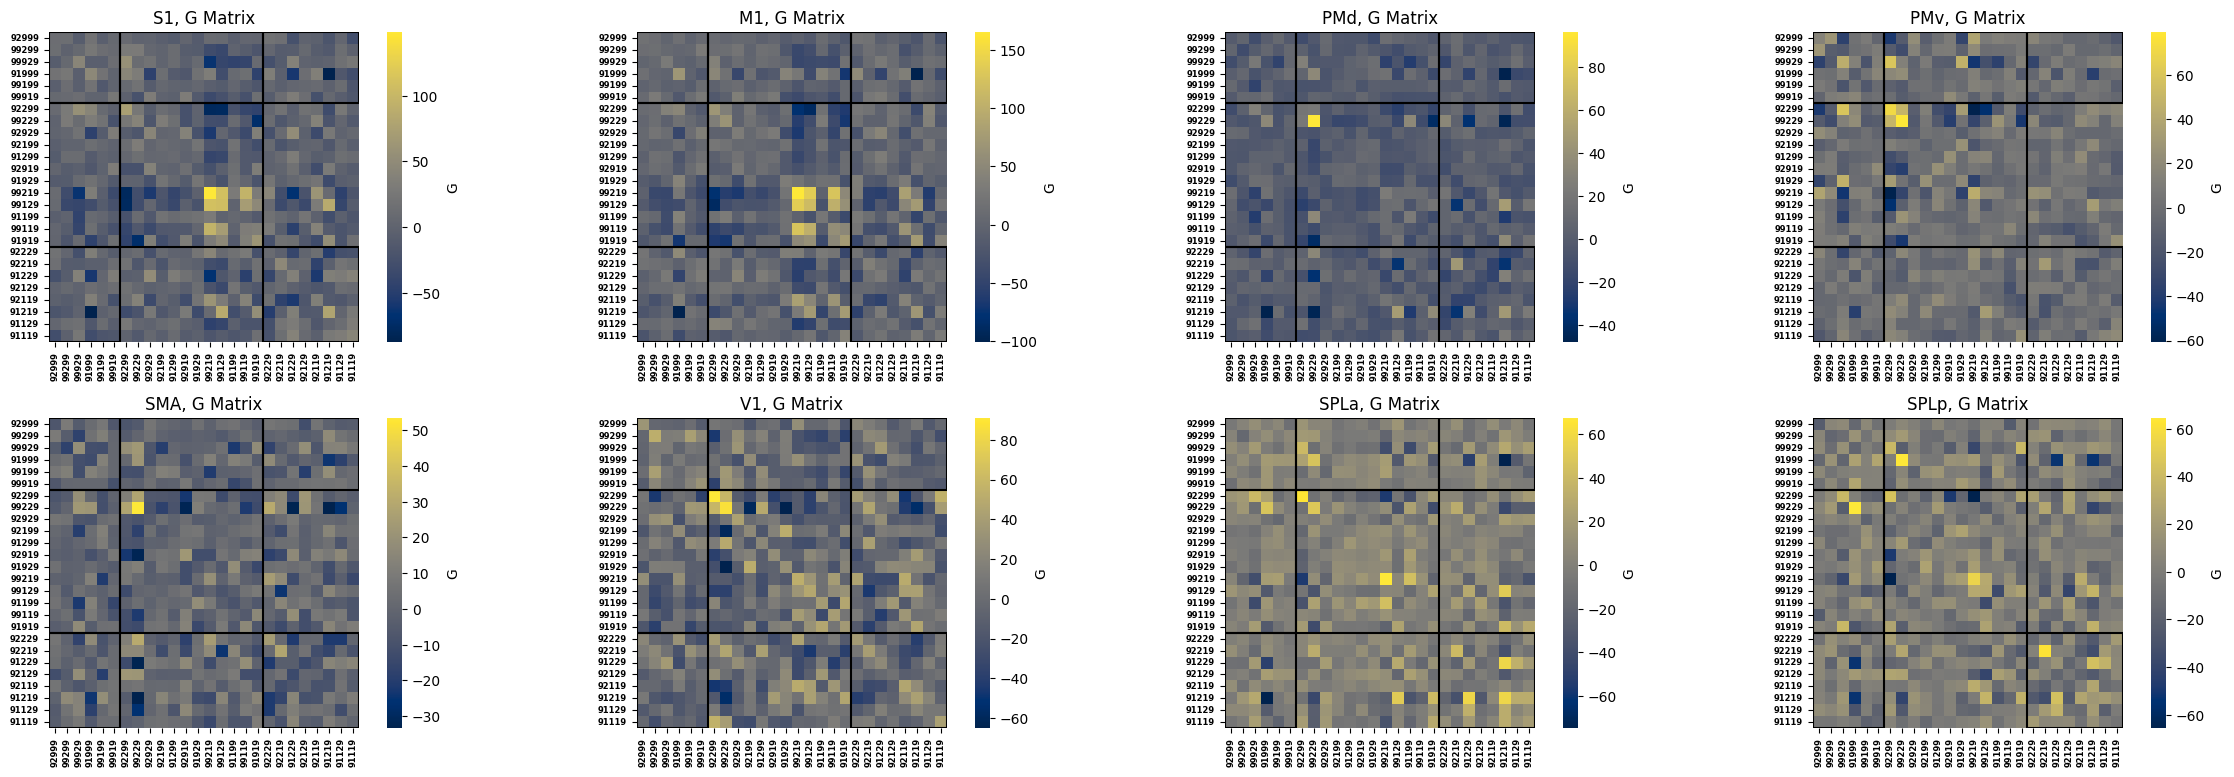

In [29]:
conditions = np.unique(conds)
custom_order = np.array(['92999', '99299', '99929', '91999', '99199', '99919', 
                         '92299', '99229', '92929', '92199', '91299', '92919', '91929', '99219', '99129', '91199', '99119', '91919',
                         '92229', '92219', '91229', '92129', '92119', '91219', '91129', '91119'])

# Create a mapping of values to their rank in the custom order
order_map = {val: idx for idx, val in enumerate(custom_order)}
# Get sorting indices based on the custom order
sort_indices = np.argsort([order_map[val] for val in conditions])

# Squares to plot (x, y, width, height)
squares = [
    (0, 0, 6, 6), 
    (6, 6, 12, 12),
    (18, 18, 8, 8),

    (6, 0, 12, 6),
    (18, 0, 8, 6),
    
    (0, 6, 6, 12),
    (0, 18, 6, 8)
]

cm = 1/2.54  # centimeters in inches
# plot the second moment matrices:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(60*cm, 20*cm))
for i, ax in enumerate(axes.flat):
    # Apply sorting to the data
    sorted_D = D[i]
    sorted_D = sorted_D[np.ix_(sort_indices, sort_indices)] # sorted_D[sort_indices][:, sort_indices]
    sns.heatmap(sorted_D, square=True, cbar_kws={'label': 'D'}, cmap='cividis', ax=ax)
    ax.set_title(f'{region_names[i]}, Distance Matrix')
    
    # Overlay squares
    for x, y, w, h in squares:
        rect = patches.Rectangle((x, y), w, h, linewidth=1.5, edgecolor='black', facecolor='none')
        ax.add_patch(rect)

    # sort based on num fingers:
    # Set labels manually with more formatting options
    ax.set_xticks(np.arange(0,n_cond)+0.5)
    ax.set_xticklabels(custom_order, rotation=90, fontsize=6, fontweight='bold')
    ax.set_yticks(np.arange(0,n_cond)+0.5)
    ax.set_yticklabels(custom_order, rotation=0, fontsize=6, fontweight='bold')
    
plt.tight_layout()
plt.savefig(os.path.join('./figures',f'efcp_D_s{sn}_glm{glm}_ses{ses:02d}.pdf'), format='pdf', bbox_inches='tight')
plt.show()


cm = 1/2.54  # centimeters in inches
# plot the second moment matrices:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(60*cm, 20*cm))
for i, ax in enumerate(axes.flat):
    # Apply sorting to the data
    sorted_G = G_hat[i]
    sorted_D = sorted_G[np.ix_(sort_indices, sort_indices)]
    sns.heatmap(sorted_G, cmap='cividis', square=True, cbar_kws={'label': 'G'}, ax=ax)
    ax.set_title(f'{region_names[i]}, G Matrix')
    
    # Overlay squares
    for x, y, w, h in squares:
        rect = patches.Rectangle((x, y), w, h, linewidth=1.5, edgecolor='black', facecolor='none')
        ax.add_patch(rect)

    # sort based on num fingers:
    # Set labels manually with more formatting options
    ax.set_xticks(np.arange(0,n_cond)+0.5)
    ax.set_xticklabels(custom_order, rotation=90, fontsize=6, fontweight='bold')
    ax.set_yticks(np.arange(0,n_cond)+0.5)
    ax.set_yticklabels(custom_order, rotation=0, fontsize=6, fontweight='bold')
    
plt.tight_layout()
plt.savefig(os.path.join('./figures',f'efcp_G_s{sn}_glm{glm}_ses{ses:02d}.pdf'), format='pdf', bbox_inches='tight')
plt.show()